In [283]:
#| default_exp models.mlp

In [284]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# MLP
> One of the simplest neural architectures are Multi Layer Perceptrons (`MLP`) composed of stacked Fully Connected Neural Networks trained with backpropagation. Each node in the architecture is capable of modeling non-linear relationships granted by their activation functions. Novel activations like Rectified Linear Units (`ReLU`) have greatly improved the ability to fit deeper networks overcoming gradient vanishing problems that were associated with `Sigmoid` and `TanH` activations. For the forecasting task the last layer is changed to follow a auto-regression problem.<br><br>**References**<br>-[Rosenblatt, F. (1958). "The perceptron: A probabilistic model for information storage and organization in the brain."](https://psycnet.apa.org/record/1959-09865-001)<br>-[Fukushima, K. (1975). "Cognitron: A self-organizing multilayered neural network."](https://pascal-francis.inist.fr/vibad/index.php?action=getRecordDetail&idt=PASCAL7750396723)<br>-[Vinod Nair, Geoffrey E. Hinton (2010). "Rectified Linear Units Improve Restricted Boltzmann Machines"](https://www.cs.toronto.edu/~fritz/absps/reluICML.pdf)<br>

![Figure 1. Three layer MLP with autorregresive inputs.](imgs_models/mlp.png)

In [285]:
#| hide
import sys
import os
sys.path.append(os.path.dirname(sys.path[0]))

# from fastcore.test import test_eq
# from nbdev.showdoc import show_doc

In [286]:
#| export
from typing import Optional

import torch
import torch.nn as nn

from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_windows import BaseWindows

In [287]:
#| export
class MLP(BaseWindows):
    """ MLP

    Simple Multi Layer Perceptron architecture (MLP). 
    This deep neural network has constant units through its layers, each with
    ReLU non-linearities, it is trained using ADAM stochastic gradient descent.
    The network accepts static, historic and future exogenous data, flattens 
    the inputs and learns fully connected relationships against the target variable.

    **Parameters:**<br>
    `h`: int, forecast horizon.<br>
    `input_size`: int, considered autorregresive inputs (lags), y=[1,2,3,4] input_size=2 -> lags=[1,2].<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `exclude_insample_y`: bool=False, the model skips the autoregressive features y[t-input_size:t] if True.<br>
    `n_layers`: int, number of layers for the MLP.<br>
    `hidden_size`: int, number of units for each layer of the MLP.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int=32, number of different series in each batch.<br>
    `valid_batch_size`: int=None, number of different series in each validation and test batch, if None uses batch_size.<br>
    `windows_batch_size`: int=1024, number of windows to sample in each training batch, default uses all.<br>
    `inference_windows_batch_size`: int=-1, number of windows to sample in each inference batch, -1 uses all.<br>
    `step_size`: int=1, step size between each window of temporal data.<br>
    `scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `alias`: str, optional,  Custom name of the model.<br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    
    """
    # Class attributes
    SAMPLING_TYPE = 'windows'
    
    def __init__(self,
                 h,
                 input_size,
                 futr_exog_list = None,
                 hist_exog_list = None,
                 stat_exog_list = None,
                 exclude_insample_y = False,
                 num_layers = 2,
                 hidden_size = 1024,
                 loss = MAE(),
                 valid_loss = None,
                 max_steps: int = 1000,
                 learning_rate: float = 1e-3,
                 num_lr_decays: int = -1,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size: int = 32,
                 valid_batch_size: Optional[int] = None,
                 windows_batch_size = 1024,
                 inference_windows_batch_size = -1,
                 step_size: int = 1,
                 scaler_type: str = 'identity',
                 random_seed: int = 1,
                 num_workers_loader: int = 0,
                 drop_last_loader: bool = False,
                 **trainer_kwargs):

        # Inherit BaseWindows class
        super(MLP, self).__init__(h=h,
                                  input_size=input_size,
                                  futr_exog_list=futr_exog_list,
                                  hist_exog_list=hist_exog_list,
                                  stat_exog_list=stat_exog_list,
                                  exclude_insample_y = exclude_insample_y,
                                  loss=loss,
                                  valid_loss=valid_loss,
                                  max_steps=max_steps,
                                  learning_rate=learning_rate,
                                  num_lr_decays=num_lr_decays,
                                  early_stop_patience_steps=early_stop_patience_steps,
                                  val_check_steps=val_check_steps,
                                  batch_size=batch_size,
                                  valid_batch_size=valid_batch_size,
                                  windows_batch_size=windows_batch_size,
                                  inference_windows_batch_size=inference_windows_batch_size,
                                  step_size=step_size,
                                  scaler_type=scaler_type,
                                  num_workers_loader=num_workers_loader,
                                  drop_last_loader=drop_last_loader,
                                  random_seed=random_seed,
                                  **trainer_kwargs)

        # Architecture
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.futr_input_size = len(self.futr_exog_list)
        self.hist_input_size = len(self.hist_exog_list)
        self.stat_input_size = len(self.stat_exog_list)

        input_size_first_layer = input_size + self.hist_input_size * input_size + \
                                 self.futr_input_size*(input_size + h) + self.stat_input_size

        # MultiLayer Perceptron
        layers = [nn.Linear(in_features=input_size_first_layer, out_features=hidden_size)]
        for i in range(num_layers - 1):
            layers += [nn.Linear(in_features=hidden_size, out_features=hidden_size)]
        self.mlp = nn.ModuleList(layers)

        # Adapter with Loss dependent dimensions
        self.out = nn.Linear(in_features=hidden_size, 
                             out_features=h * self.loss.outputsize_multiplier)

    def forward(self, windows_batch):

        # Parse windows_batch
        insample_y    = windows_batch['insample_y']
        futr_exog     = windows_batch['futr_exog']
        hist_exog     = windows_batch['hist_exog']
        stat_exog     = windows_batch['stat_exog']

        # Flatten MLP inputs [B, L+H, C] -> [B, (L+H)*C]
        # Contatenate [ Y_t, | X_{t-L},..., X_{t} | F_{t-L},..., F_{t+H} | S ]
        batch_size = len(insample_y)
        if self.hist_input_size > 0:
            insample_y = torch.cat(( insample_y, hist_exog.reshape(batch_size,-1) ), dim=1)

        if self.futr_input_size > 0:
            insample_y = torch.cat(( insample_y, futr_exog.reshape(batch_size,-1) ), dim=1)

        if self.stat_input_size > 0:
            insample_y = torch.cat(( insample_y, stat_exog.reshape(batch_size,-1) ), dim=1)

        y_pred = insample_y.clone()
        for layer in self.mlp:
             y_pred = torch.relu(layer(y_pred))
        y_pred = self.out(y_pred)

        y_pred = y_pred.reshape(batch_size, self.h, 
                                self.loss.outputsize_multiplier)
        y_pred = self.loss.domain_map(y_pred)
        return y_pred

In [288]:
# show_doc(MLP)

In [289]:
# show_doc(MLP.fit, name='MLP.fit')

In [290]:
# show_doc(MLP.predict, name='MLP.predict')

In [291]:
#| hide
import logging
import warnings
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

Global seed set to 1


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 286.46it/s]


<Axes: xlabel='ds'>

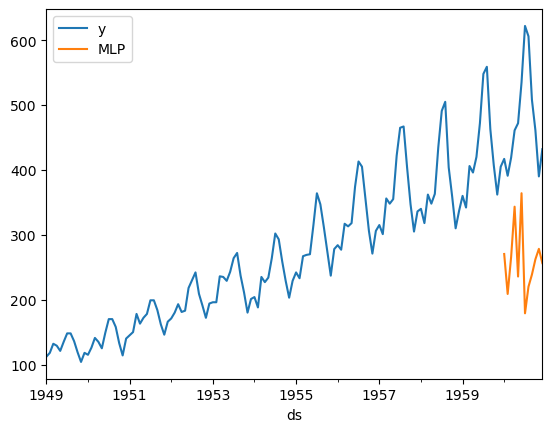

In [292]:
#| hide
# test performance fit/predict method
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast.utils import AirPassengersDF as Y_df
from neuralforecast.tsdataset import TimeSeriesDataset


Y_train_df = Y_df[Y_df.ds<='1959-12-31'] # 132 train
Y_test_df = Y_df[Y_df.ds>'1959-12-31']   # 12 test

dataset, *_ = TimeSeriesDataset.from_df(Y_train_df)
model = MLP(h=12, input_size=24, max_steps=1)
model.fit(dataset=dataset)
y_hat = model.predict(dataset=dataset)
Y_test_df['MLP'] = y_hat

#test we recover the same forecast
y_hat2 = model.predict(dataset=dataset)
# test_eq(y_hat, y_hat2)

pd.concat([Y_train_df, Y_test_df]).drop('unique_id', axis=1).set_index('ds').plot()

In [293]:
#| hide
# test no leakage with test_size
dataset, *_ = TimeSeriesDataset.from_df(Y_df)
model = MLP(h=12, input_size=24, max_steps=1)
model.fit(dataset=dataset, test_size=12)
y_hat_test = model.predict(dataset=dataset, step_size=1)
np.testing.assert_almost_equal(
    y_hat, 
    y_hat_test,
    decimal=4
)
# test we recover the same forecast
y_hat_test2 = model.predict(dataset=dataset, step_size=1)
# test_eq(y_hat_test, y_hat_test2)

Global seed set to 1


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.01it/s]


Global seed set to 1


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.82it/s]


<Axes: xlabel='ds'>

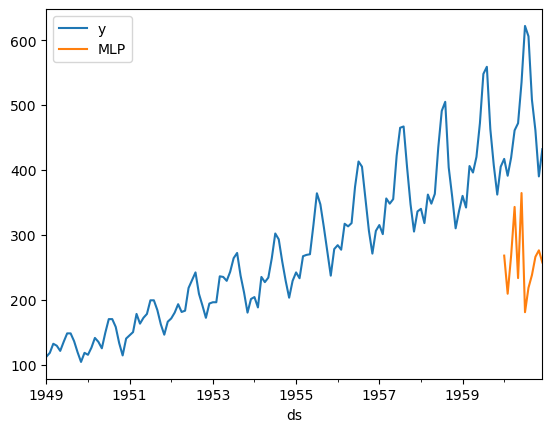

In [294]:
#| hide
# test validation step
dataset, *_ = TimeSeriesDataset.from_df(Y_train_df)
model = MLP(h=12, input_size=24, step_size=1, 
            hidden_size=1024, num_layers=2,
            max_steps=1)
model.fit(dataset=dataset, val_size=12)
y_hat_w_val = model.predict(dataset=dataset)
Y_test_df['MLP'] = y_hat_w_val

pd.concat([Y_train_df, Y_test_df]).drop('unique_id', axis=1).set_index('ds').plot()

In [295]:
#| hide
# test no leakage with test_size and val_size
dataset, *_ = TimeSeriesDataset.from_df(Y_df)
model = MLP(h=12, input_size=24, step_size=1, 
            hidden_size=1024, num_layers=2,
            max_steps=1)
model.fit(dataset=dataset, val_size=12, test_size=12)
y_hat_test_w_val = model.predict(dataset=dataset, step_size=1)
np.testing.assert_almost_equal(y_hat_test_w_val,
                               y_hat_w_val, decimal=4)

Global seed set to 1


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.96it/s]


## Usage Example

In [296]:
#| eval: false
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import MLP
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

# 读取文件
df = pd.read_csv('../dataset/ETDataset-main/ETTh1.csv')
df

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778000


In [297]:
# 数据集必须的格式
Y_df = df[['date','OT']]
Y_df.columns = ['ds','y']
Y_df['unique_id'] = 'ETTh1'
Y_df['ds'] = pd.to_datetime(Y_df['ds'])
Y_df.head()

,ds,y,unique_id
0,2016-07-01 00:00:00,30.531000,ETTh1
1,2016-07-01 01:00:00,27.787001,ETTh1
2,2016-07-01 02:00:00,27.787001,ETTh1
3,2016-07-01 03:00:00,25.044001,ETTh1
4,2016-07-01 04:00:00,21.948000,ETTh1


In [298]:
horizon = 24 
Y_test_df = Y_df.tail(horizon*7)  # 获取最后 horizon*2 行作为一部分
Y_train_df = Y_df.iloc[:-horizon*7]  # 获取除了最后 horizon*2 行之外的其余部分

In [299]:
model = MLP(
    h=horizon,
    input_size=horizon*7,
    loss=DistributionLoss(distribution="Normal"),
    scaler_type="robust",
    learning_rate=1e-5,
    max_steps=100,
    val_check_steps=10,
)

fcst = NeuralForecast(models=[model], freq="H")
fcst.fit(df=Y_train_df)
forecasts = fcst.predict(futr_df=Y_test_df)

Global seed set to 1


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.22it/s]


In [300]:
forecasts

,ds,MLP,MLP-median,MLP-lo-90,MLP-lo-80,MLP-hi-80,MLP-hi-90
unique_id,,,,,,,
ETTh1,2018-06-19 20:00:00,8.676806,8.710234,6.607600,7.080823,10.190400,10.581286
ETTh1,2018-06-19 21:00:00,8.748785,8.747047,6.733299,7.146623,10.387628,10.777590
ETTh1,2018-06-19 22:00:00,8.540689,8.553044,6.646485,7.036517,10.076968,10.473969
ETTh1,2018-06-19 23:00:00,8.952314,8.972578,6.795853,7.328640,10.613469,11.024457
ETTh1,2018-06-20 00:00:00,8.382207,8.341644,6.110148,6.565393,10.225111,10.701512
ETTh1,2018-06-20 01:00:00,8.557505,8.569567,6.426483,6.829854,10.269074,10.705220
ETTh1,2018-06-20 02:00:00,8.818583,8.842651,6.889135,7.289973,10.308195,10.711384
ETTh1,2018-06-20 03:00:00,8.366675,8.350929,6.284376,6.733238,9.967714,10.451480
ETTh1,2018-06-20 04:00:00,8.502829,8.576425,6.340912,6.819407,10.101205,10.631962


<Axes: >

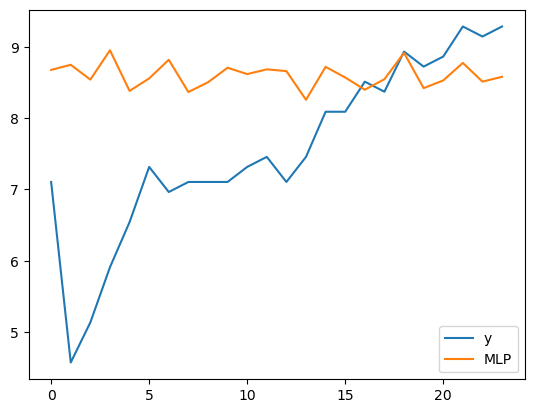

In [301]:
modelname = 'MLP'
original_data = pd.merge(Y_df, forecasts, on='ds', how='inner')
original_data[['y', modelname]].plot()


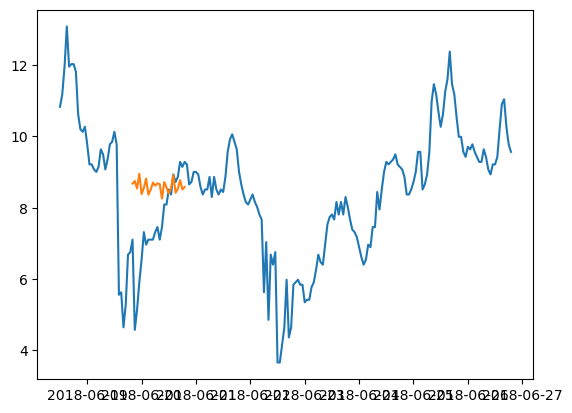

In [302]:
original = Y_df[-200:]
plt.plot(original['ds'],original['y'])
plt.plot(original_data['ds'],original_data['MLP'])